In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Mounted at /content/drive


### Merging KPK grids

In [ ]:
import os
import glob
import re
import pandas as pd

# Path to KPK's daily data folder
file_path = "/content/drive/MyDrive/FYP/cleaned_data/Daily/kpk_heatwave_cities/"

# Get all CSV file paths
csv_files = glob.glob(os.path.join(file_path, "*.csv"))
print(f"Found {len(csv_files)} files in KPK directory.")  # Debugging step

# Define optimized data types for memory efficiency
dtype_mapping = {
    "temperature_2m_max": "float32",
    "temperature_2m_min": "float32",
    "precipitation_sum": "float32",
    "wind_speed_10m_max": "float32",
    "wind_gusts_10m_max": "float32",
    "wind_direction_10m_dominant": "float32",
    "shortwave_radiation_sum": "float32",
    "et0_fao_evapotranspiration": "float32"
}

# List to store individual DataFrames
df_list = []

# Regex pattern to extract grid number (assumes "Grid_X" format in filename)
grid_pattern = re.compile(r"Grid_(\d+)")

# Read each CSV, extract grid ID, and append to the list
for file in csv_files:
    match = grid_pattern.search(file)
    if match:
        grid_id = int(match.group(1))  # Extract grid number
    else:
        print(f"Warning: Could not extract grid ID from {file}")
        continue  # Skip file if no grid ID found

    df = pd.read_csv(file, dtype=dtype_mapping, parse_dates=["date"])
    df["grid_id"] = grid_id  # Add grid ID column
    df_list.append(df)

# Concatenate all DataFrames
kpk_df = pd.concat(df_list, ignore_index=True)

# Sort by date and grid ID (to keep structure consistent)
kpk_df = kpk_df.sort_values(by=["grid_id", "date"]).reset_index(drop=True)

# Display basic info
print(kpk_df.info())
kpk_df.describe()

# Save merged file
output_path = "/content/drive/MyDrive/FYP/processed_data/kpk_merged.parquet"
kpk_df.to_parquet(output_path, engine="pyarrow", index=False)
print(f"KPK data saved at: {output_path}")


KPK data saved at: /content/drive/MyDrive/FYP/processed_data/kpk_merged.parquet


### Feature Engineering

In [ ]:
import pandas as pd

# Load the merged kpk dataset
kpk_df = pd.read_parquet("/content/drive/MyDrive/FYP/processed_data/kpk_merged.parquet")

# Ensure data is sorted before applying rolling calculations
kpk_df = kpk_df.sort_values(by=["grid_id", "date"]).reset_index(drop=True)

# Create date-based features
kpk_df["year"] = kpk_df["date"].dt.year
kpk_df["month"] = kpk_df["date"].dt.month
kpk_df["day"] = kpk_df["date"].dt.day
kpk_df["day_of_year"] = kpk_df["date"].dt.dayofyear
kpk_df["week_of_year"] = kpk_df["date"].dt.isocalendar().week
kpk_df["season"] = kpk_df["month"].map({12: "winter", 1: "winter", 2: "winter",
                                                         3: "spring", 4: "spring", 5: "spring",
                                                         6: "summer", 7: "summer", 8: "summer",
                                                         9: "fall", 10: "fall", 11: "fall"})

# Compute rolling averages
kpk_df["temp_7d_avg"] = kpk_df.groupby("grid_id")["temperature_2m_mean"].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
kpk_df["temp_14d_avg"] = kpk_df.groupby("grid_id")["temperature_2m_mean"].transform(lambda x: x.rolling(window=14, min_periods=1).mean())

# Compute heatwave threshold (90th percentile of past temperatures per grid)
heatwave_thresholds = kpk_df.groupby("grid_id")["temperature_2m_mean"].quantile(0.90).to_dict()
kpk_df["heatwave_threshold"] = kpk_df["grid_id"].map(heatwave_thresholds)

# Define binary heatwave labels
kpk_df["is_heatwave_day"] = (kpk_df["temperature_2m_mean"] > kpk_df["heatwave_threshold"]).astype(int)

# Apply consecutive heatwave labeling (3+ consecutive hot days)
kpk_df["heatwave_final"] = kpk_df.groupby("grid_id")["is_heatwave_day"].transform(lambda x: x.rolling(window=3, min_periods=1).sum() >= 3).astype(int)

# Save processed file
output_path = "/content/drive/MyDrive/FYP/processed_data/kpk_features.parquet"
kpk_df.to_parquet(output_path, engine="pyarrow", index=False)
print(f"Feature engineered data saved at: {output_path}")

# Drop unnecessary columns
kpk_df = kpk_df.drop(columns=["temperature_2m_max", "temperature_2m_min", "wind_gusts_10m_max"])

# Save the updated dataset
output_path = "/content/drive/MyDrive/FYP/processed_data/kpk_features.parquet"
kpk_df.to_parquet(output_path, engine="pyarrow", index=False)

print(f"Updated dataset saved at: {output_path}")

# Display summary
print(kpk_df.info())


KeyError: "['temperature_2m_max', 'temperature_2m_min', 'wind_gusts_10m_max'] not found in axis"

### EDA

In [ ]:
print(kpk_df.info())  # Column types and non-null counts
  # Summary stats
print(kpk_df.isnull().sum())  # Missing values check

Index(['date', 'temperature_2m_mean', 'precipitation_sum',
       'wind_speed_10m_max', 'wind_direction_10m_dominant',
       'shortwave_radiation_sum', 'et0_fao_evapotranspiration', 'grid_id',
       'year', 'month', 'day', 'day_of_year', 'week_of_year', 'season',
       'temp_7d_avg', 'temp_14d_avg', 'heatwave_threshold', 'is_heatwave_day',
       'heatwave_final'],
      dtype='object')

In [ ]:
# Count heatwave vs. non-heatwave days
heatwave_counts = kpk_df["heatwave_final"].value_counts()
print(heatwave_counts)
print()
print(kpk_df["is_heatwave_day"].value_counts(normalize=True))

heatwave_final
0    85544
1     5753
Name: count, dtype: int64

is_heatwave_day
0    0.899986
1    0.100014
Name: proportion, dtype: float64


<ipython-input-3-4a10ee747813>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=monthly_heatwaves.index, y=monthly_heatwaves.values, palette="Reds")


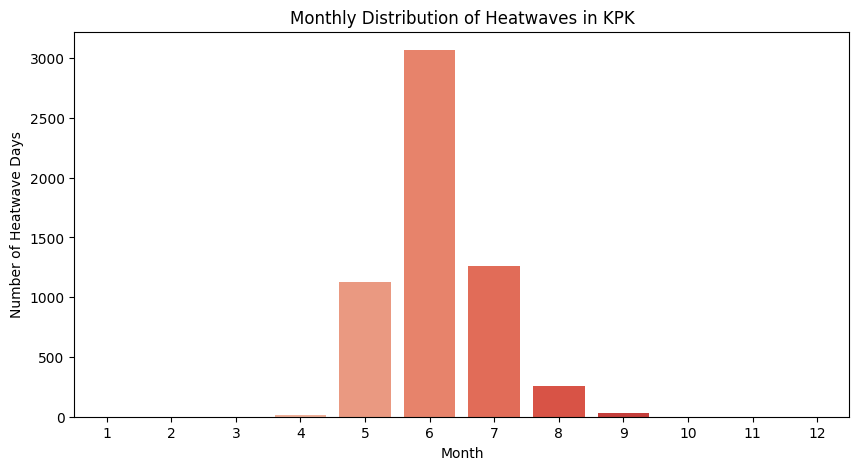

In [3]:
kpk_df = pd.read_parquet("/content/drive/MyDrive/FYP/processed_data/kpk_features.parquet")
import matplotlib.pyplot as plt
import seaborn as sns

# Count heatwave days per month
monthly_heatwaves = kpk_df.groupby("month")["heatwave_final"].sum()

plt.figure(figsize=(10, 5))
sns.barplot(x=monthly_heatwaves.index, y=monthly_heatwaves.values, palette="Reds")
plt.xlabel("Month")
plt.ylabel("Number of Heatwave Days")
plt.title("Monthly Distribution of Heatwaves in KPK")
plt.show()


### Model Training

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, precision_recall_curve
from sklearn.pipeline import Pipeline
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

# Load punjab dataset
df = pd.read_parquet('/content/drive/MyDrive/FYP/processed_data/kpk_features.parquet')
df = df.dropna(subset=['et0_fao_evapotranspiration'])

def prepare_punjab_heatwave_data(df):
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'])

    features = [
        'temperature_2m_mean', 'precipitation_sum',
        'wind_speed_10m_max', 'wind_direction_10m_dominant',
        'shortwave_radiation_sum', 'et0_fao_evapotranspiration',
        'month', 'day_of_year', 'season',
        'temp_7d_avg', 'temp_14d_avg',
        'heatwave_threshold'
    ]

    X = df[features]
    y = df['is_heatwave_day']
    return X, y, df['date']

def create_heatwave_pipeline():
    numeric_features = [
        'temperature_2m_mean', 'precipitation_sum',
        'wind_speed_10m_max', 'wind_direction_10m_dominant',
        'shortwave_radiation_sum', 'et0_fao_evapotranspiration',
        'day_of_year', 'temp_7d_avg', 'temp_14d_avg', 'heatwave_threshold'
    ]

    categorical_features = ['month', 'season']

    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', xgb.XGBClassifier(
            scale_pos_weight=9,  # Adjusted for 10% heatwave days (90/10 ≈ 9)
            n_estimators=100,
            learning_rate=0.1,
            random_state=42
        ))
    ])

    return pipeline

def evaluate_heatwave_model(pipeline, X_test, y_test):
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    avg_prec = average_precision_score(y_test, y_proba)
    print(f"\nAverage Precision Score: {avg_prec:.4f}")

    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5
    print(f"Optimal threshold: {optimal_threshold:.4f}")

    y_pred_optimal = (y_proba >= optimal_threshold).astype(int)
    print("\nClassification Report with Optimal Threshold:")
    print(classification_report(y_test, y_pred_optimal))

    return y_pred, y_proba, optimal_threshold

def feature_importance_analysis(pipeline, X):
    preprocessor = pipeline.named_steps['preprocessor']

    numeric_features = [
        'temperature_2m_mean', 'precipitation_sum',
        'wind_speed_10m_max', 'wind_direction_10m_dominant',
        'shortwave_radiation_sum', 'et0_fao_evapotranspiration',
        'day_of_year', 'temp_7d_avg', 'temp_14d_avg', 'heatwave_threshold'
    ]

    categorical_features = ['month', 'season']
    cat_encoder = preprocessor.named_transformers_['cat']
    cat_feature_names = list(cat_encoder.get_feature_names_out(categorical_features))
    feature_names = numeric_features + cat_feature_names

    classifier = pipeline.named_steps['classifier']
    importances = classifier.feature_importances_

    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    print("\nFeature Importances:")
    print(importance_df.head(10))

    return importance_df

def main(df):
    X, y, dates = prepare_punjab_heatwave_data(df)

    print("Class Distribution:")
    print(y.value_counts(normalize=True))

    split_idx = int(len(df) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    print(f"Training set size: {X_train.shape[0]} samples")
    print(f"Test set size: {X_test.shape[0]} samples")

    pipeline = create_heatwave_pipeline()
    pipeline.fit(X_train, y_train)

    y_pred, y_proba, optimal_threshold = evaluate_heatwave_model(pipeline, X_test, y_test)
    importance_df = feature_importance_analysis(pipeline, X)

    return pipeline, importance_df, optimal_threshold

# Run for punjab dataset
model, feature_importance, threshold = main(df)


Class Distribution:
is_heatwave_day
0    0.899986
1    0.100014
Name: proportion, dtype: float64
Training set size: 73037 samples
Test set size: 18260 samples

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97     16433
           1       0.71      0.91      0.80      1827

    accuracy                           0.95     18260
   macro avg       0.85      0.93      0.89     18260
weighted avg       0.96      0.95      0.96     18260


Confusion Matrix:
[[15758   675]
 [  163  1664]]

Average Precision Score: 0.9415
Optimal threshold: 0.9981

Classification Report with Optimal Threshold:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     16433
           1       0.87      0.80      0.83      1827

    accuracy                           0.97     18260
   macro avg       0.92      0.89      0.91     18260
weighted avg       0.97      0.97      0.97     18260


Featur

### Save the Model

In [5]:
import joblib

# Save the trained model
joblib.dump(model, "/content/drive/MyDrive/FYP/processed_data/heatwave_kpk_XGB.pkl")  # Update path if needed


['/content/drive/MyDrive/FYP/processed_data/heatwave_kpk_XGB.pkl']

### Verifying prediction from historical data

In [6]:
#import joblib
#model = joblib.load("/content/drive/MyDrive/FYP/processed_data/heatwave_sindh_XGB.pkl")

import pandas as pd

# Load dataset again (if needed)
df = pd.read_parquet('/content/drive/MyDrive/FYP/processed_data/kpk_features.parquet')
#df = df_karachi.dropna(subset=['et0_fao_evapotranspiration'])

df_lahore = df[df["grid_id"] == 136 ]
#df=df_lahore
# Step 1: Sort by date
df_lahore = df_lahore.sort_values(by="date")

# Step 2: Compute rolling averages
#df["temp_7d_avg"] = df["temperature_2m_mean"].rolling(window=7, min_periods=1).mean()
#df["temp_14d_avg"] = df["temperature_2m_mean"].rolling(window=14, min_periods=1).mean()

# Step 3: Filter for June 18-24, 2024
df_june = df_lahore[(df_lahore["date"] >= "2024-05-15") & (df_lahore["date"] <= "2024-06-15")]

# Drop the target variable (if present)
X_new = df_june.drop(columns=["is_heatwave_day"], errors="ignore")

# Step 4: Apply the same preprocessing pipeline
X_new_transformed = model.named_steps["preprocessor"].transform(X_new)

# Step 5: Predict
predictions = model.named_steps["classifier"].predict(X_new_transformed)

# Step 6: Add predictions to DataFrame
df_june["predicted_heatwave"] = predictions

# Step 7: Show results
df_june[["date", "temperature_2m_mean", "predicted_heatwave"]]

<ipython-input-6-8b82008335e6>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_june["predicted_heatwave"] = predictions


,date,temperature_2m_mean,predicted_heatwave
54548,2024-05-15 19:00:00+00:00,30.585165,0
54549,2024-05-16 19:00:00+00:00,31.764334,0
54550,2024-05-17 19:00:00+00:00,31.337252,0
54551,2024-05-18 19:00:00+00:00,31.183080,0
54552,2024-05-19 19:00:00+00:00,31.593498,0
54553,2024-05-20 19:00:00+00:00,32.493500,0
54554,2024-05-21 19:00:00+00:00,33.485170,1
54555,2024-05-22 19:00:00+00:00,33.493504,1
54556,2024-05-23 19:00:00+00:00,32.839333,0
54557,2024-05-24 19:00:00+00:00,34.085170,1


### Verifying from cleaned data

In [14]:
import pandas as pd
import joblib

# Load trained model
model = joblib.load("/content/drive/MyDrive/FYP/processed_data/heatwave_kpk_XGB.pkl")

# Load Grid 4 data
file_path = "/content/drive/MyDrive/FYP/cleaned_data/Daily/kpk_heatwave_cities/Copy of Grid_67_daily_kpk.csv"
df = pd.read_csv(file_path, parse_dates=['date'])

# Sort by date
df = df.sort_values(by="date")

df["temp_7d_avg"] = df["temperature_2m_mean"].rolling(window=7, min_periods=1).mean()
df["temp_14d_avg"] = df["temperature_2m_mean"].rolling(window=14, min_periods=1).mean()

# Drop rows where 'et0_fao_evapotranspiration' is missing
#df = df.dropna(subset=['et0_fao_evapotranspiration'])

# Feature Engineering: Add Missing Features
df["month"] = df["date"].dt.month
df["day_of_year"] = df["date"].dt.dayofyear

# Map seasons (based on your previous work)
def get_season(month):
    if month in [12, 1, 2]: return "Winter"
    elif month in [3, 4, 5]: return "Spring"
    elif month in [6, 7, 8]: return "Summer"
    else: return "Autumn"

df["season"] = df["month"].apply(get_season)

# Load Sindh-wide dataset to get original heatwave threshold
#punjab_df = pd.read_parquet('/content/drive/MyDrive/FYP/processed_data/punjab_features.parquet')

# Get the heatwave threshold used in training
#global_heatwave_threshold = np.percentile(df["temperature_2m_mean"], 90)
global_heatwave_threshold=kpk_df["heatwave_threshold"].unique()[0]

# Apply this fixed threshold to Grid 4
df["heatwave_threshold"] = global_heatwave_threshold

#df["heatwave_threshold"] = df["temperature_2m_max"].quantile(0.95)
# Filter for June 18-24, 2024
df_filtered = df[(df["date"] >= "2015-06-01") & (df["date"] <= "2015-06-25")]

# Drop target variable if present
X_new = df_filtered.drop(columns=["is_heatwave_day"], errors="ignore")

# Apply preprocessing pipeline
X_new_transformed = model.named_steps["preprocessor"].transform(X_new)

# Predict heatwave occurrence
predictions = model.named_steps["classifier"].predict(X_new_transformed)

# Store predictions in DataFrame
df_filtered["predicted_heatwave"] = predictions

# Show results
df_filtered[["date", "temperature_2m_mean", "predicted_heatwave"]]



<ipython-input-14-608168e475f8>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["predicted_heatwave"] = predictions


,date,temperature_2m_mean,predicted_heatwave
5629,2015-06-01 19:00:00+00:00,32.156086,0
5630,2015-06-02 19:00:00+00:00,29.781090,0
5631,2015-06-03 19:00:00+00:00,29.737335,0
5632,2015-06-04 19:00:00+00:00,31.137330,0
5633,2015-06-05 19:00:00+00:00,32.710247,0
5634,2015-06-06 19:00:00+00:00,35.087337,1
5635,2015-06-07 19:00:00+00:00,35.814420,1
5636,2015-06-08 19:00:00+00:00,35.951916,1
5637,2015-06-09 19:00:00+00:00,34.554005,1
5638,2015-06-10 19:00:00+00:00,33.422752,1
